### Connect to Google Drive



In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Produce Labels




#### Unsupervised Learning - KMeans Clustering


In this section, K-Means clustering is used to create labels which approximately correspond to cloud coverage.

##### Install Dependencies

In [38]:
!pip install rasterio

##### Import Libraries

In [39]:
import os
import rasterio
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

##### Read and Reshape Image Data

In [40]:
base_path = "/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/GRANULE/L2A_T30VVH_A046552_20240521T113318/IMG_DATA/R10m/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T30VVH_20240521T113321_B04_10m.jp2',
    'B3': base_path + 'T30VVH_20240521T113321_B03_10m.jp2',
    'B2': base_path + 'T30VVH_20240521T113321_B02_10m.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for K-means, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))


##### Run K-Means Clustering

In [41]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Verify Shapes
print(labels_image.shape)
print(band_stack.shape)
print(X.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10980, 10980)
(10980, 10980, 3)
(120559956, 3)


##### Plot K-Means Label Image


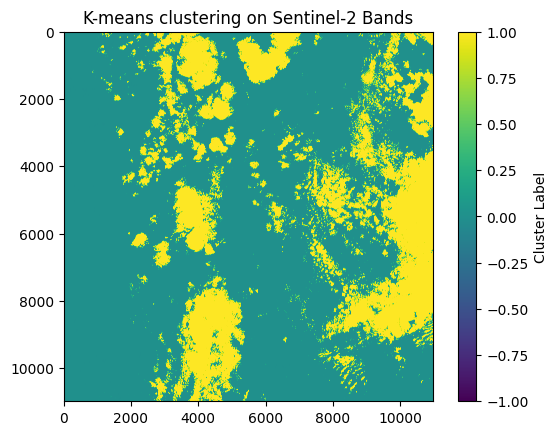

In [42]:
# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('K-means clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()

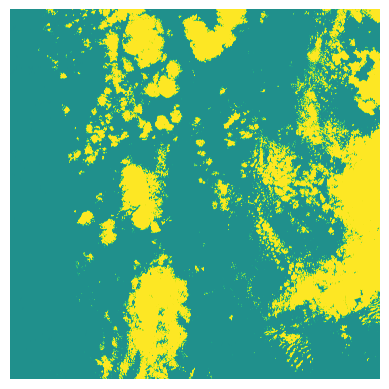

In [43]:
# Plotting the result without axis
plt.imshow(labels_image)
plt.axis('off')
plt.show()

Focusssing on a Region of Interest (ROI)

In [44]:
# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [3000, 8000, 4000, 9000]

# Extracting the region of interest (ROI) from the image
roi = band_stack[y1:y2, x1:x2]
roi_labels = labels_image[y1:y2, x1:x2]

print(roi.shape)
print(roi_labels.shape)

(1000, 1000, 3)
(1000, 1000)


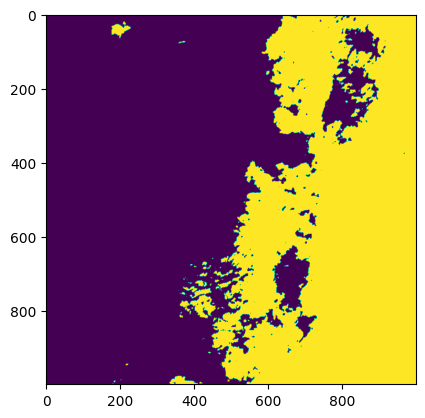

In [45]:
# Plot Labels for Region of interest
plt.imshow(roi_labels, cmap='viridis')
plt.show()

#### Supervised Learning - Convolution Neural Networks (CNN)

Having produced cloud coverage labels, this section trains and evaluates a classification model. The classification model uses a Convultional Neural Network (CNN) based architecture, trained using supervised learning.



##### Patch Extraction for Convolution Neural Networks (CNN) Model Inouts

In [46]:
patches = []

for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)

(996004, 3, 3, 3)


##### Trim Labels Array to Remove the Boarders

In [47]:
# Trim the image to exclude boundary labels
trimmed_mask = roi_labels[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)

(996004,)


##### Import Libraries

In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

##### Class Balancing

In [49]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 2 # Adjust it to the amount you get

{0: 595486, 1: 400518}


In [50]:
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample the same number of indices as class 1 from class 0
num_class = len(indices_class_1)
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]

# Split the balanced dataset into training and testing sets with a 90:10 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

# Check the balance in y_train_balanced
unique, counts = np.unique(y_test_balanced, return_counts=True)
print(dict(zip(unique, counts)))


{0: 360420, 1: 360512}
{0: 40098, 1: 40006}


Data for CNN Model

In [51]:
np.save(os.path.join('/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/', 'X_train_balanced.npy'), X_train_balanced)
np.save(os.path.join('/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/', 'X_test_balanced.npy'), X_test_balanced)
np.save(os.path.join('/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/', 'y_train_balanced.npy'), y_train_balanced)
np.save(os.path.join('/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/', 'y_test_balanced.npy'), y_test_balanced)

In [52]:
X_train_path = '/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/X_train_balanced.npy'
X_test_path = '/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/X_test_balanced.npy'
Y_train_path = '/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/y_train_balanced.npy'
Y_test_path = '/content/drive/MyDrive/AIProject/S2A_MSIL2A_20240521T113321_N0510_R080_T30VVH_20240521T164358.SAFE/y_test_balanced.npy'

In [53]:
# Load the training and validation data
X_train = np.load(X_train_path)
X_val = np.load(X_test_path)
y_train = np.load(Y_train_path)
y_val = np.load(Y_test_path)

##### Check GPU Availability

In [54]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable device placement logging
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


##### Fit Convolutional Neural Network (CNN)

In [55]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 3), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
22530/22530 [==============================] - 65s 3ms/step - loss: 1.8288 - accuracy: 0.9104 - val_loss: 0.0580 - val_accuracy: 0.9906
Epoch 2/10
22530/22530 [==============================] - 64s 3ms/step - loss: 0.0760 - accuracy: 0.9698 - val_loss: 0.0563 - val_accuracy: 0.9705
Epoch 3/10
22530/22530 [==============================] - 64s 3ms/step - loss: 0.0642 - accuracy: 0.9739 - val_loss: 0.0564 - val_accuracy: 0.9736
Epoch 4/10
22530/22530 [==============================] - 63s 3ms/step - loss: 0.0607 - accuracy: 0.9752 - val_loss: 0.0647 - val_accuracy: 0.9677
Epoch 5/10
22530/22530 [==============================] - 64s 3ms/step - loss: 0.0570 - accuracy: 0.9775 - val_loss: 0.0714 - val_accuracy: 0.9654
Epoch 6/10
22530/22530 [==============================] - 63s 3ms/step - loss: 0.0539 - accuracy: 0.9792 - val_loss: 0.0389 - val_accuracy: 0.9815
Epoch 7/10
22530/22530 [==============================] - 64s 3ms/step - loss: 0.0496 - accuracy: 0.9807 - val_loss: 0

##### Plot the Predictions for the ROI

3985/3985 [==============================] - 5s 1ms/step
Unique predicted labels: [0 1]
Shape of map1: (998, 998)
Unique values in map1: [0 1]


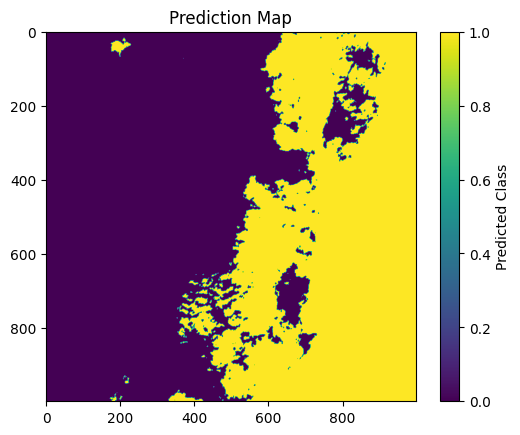

In [56]:
# Make predictions on the image
# Assuming patches_array contains the image patches
patches_array_shape = (roi.shape[0] - 2, roi.shape[1] - 2, 3, 3, 3)  # Adjusted to match extracted patch dimensions

# Make predictions on the image
y_pred = model.predict(patches_array, batch_size=250)

# Convert predictions to class labels
y_pred1 = np.argmax(y_pred, axis=1)

# Debug: Check unique values in predicted labels
unique_labels = np.unique(y_pred1)
print("Unique predicted labels:", unique_labels)

# Reshape predictions to match the original spatial dimensions of the ROI
map1 = y_pred1.reshape(patches_array_shape[0], patches_array_shape[1])

# Debug: Check shape and content of map1
print("Shape of map1:", map1.shape)
print("Unique values in map1:", np.unique(map1))

# Show the prediction map
plt.imshow(map1, cmap='viridis')
plt.title('Prediction Map')
plt.colorbar(label='Predicted Class')
plt.show()

##### Calculate Validation Loss & Accuracy

In [57]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


2504/2504 [==============================] - 5s 2ms/step - loss: 0.0325 - accuracy: 0.9873
Validation Loss: 0.03252312168478966
Validation Accuracy: 0.9873414635658264
2504/2504 [==============================] - 3s 1ms/step


##### Evaluate the Model

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     40098
           1       0.98      1.00      0.99     40006

    accuracy                           0.99     80104
   macro avg       0.99      0.99      0.99     80104
weighted avg       0.99      0.99      0.99     80104

Confusion Matrix:
[[39088  1010]
 [    4 40002]]


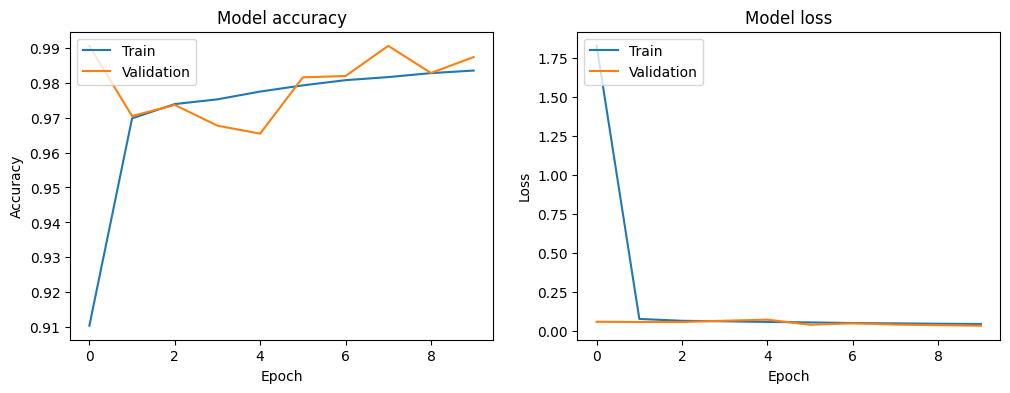

In [58]:
# Calculate precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_val, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_classes))

# Plot training & validation accuracy values
history = history.history

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


##### Interpretation

The classification report and confusion matrix provide a detailed overview of the model's performance on the validation set. The model demonstrates high precision and recall for both classes, indicating that it is very effective at correctly identifying both class 0 and class 1 instances. Class 0 has a slightly lower recall (0.97), indicating that there are some instances of class 0 that are being misclassified as class 1. Class 1 has almost perfect metrics, with very high precision and perfect recall.
The overall accuracy is very high (0.99), suggesting that the model performs exceptionally well on the validation data. The confusion matrix supports the classification report, showing a small number of misclassifications, primarily false positives for class 1.

##### Future Improvements

This project successfully demonstrates the use of machine learning techniques for land cover classification. However, there are several areas where improvements could be made to improve the robustness and generalisability of this model.

The current application focuses on a binary classification problem, which might be too simplistic for real-world land cover classification tasks. Expanding the classification problem to a multi-class scenario would provide more detailed and useful information.

The labels used for training the CNN were produced using K-means clustering. This means that the CNN model is essentially learning to replicate the clustering results. While this can be a useful approach for initial segmentation, it limits the model's ability to learn more nuanced features that might not be captured by K-means. Incorporating additional labeled data or more sophisticated labeling techniques could improve the model's usefulness.

The approach of extracting patches for both training and validation might lead to data leakage if patches from the same region are included in both sets. This can artificially inflate the model's performance metrics. To mitigate this, future work should ensure that the training and validation sets are completely independent, perhaps by splitting the data at the image level rather than the patch level.

The model demonstrates very high accuracy on the validation set, which may indicate overfitting, especially given the relatively small dataset. Overfitting occurs when the model learns the training data too well, including the noise, and fails to generalize to new, unseen data.